# references
https://docs.langchain.com/oss/python/langchain/multi-agent/router-knowledge-base

The system will coordinate three specialists:
A GitHub agent that searches code, issues, and pull requests.
A Notion agent that searches internal documentation and wikis.
A Slack agent that searches relevant threads and discussions

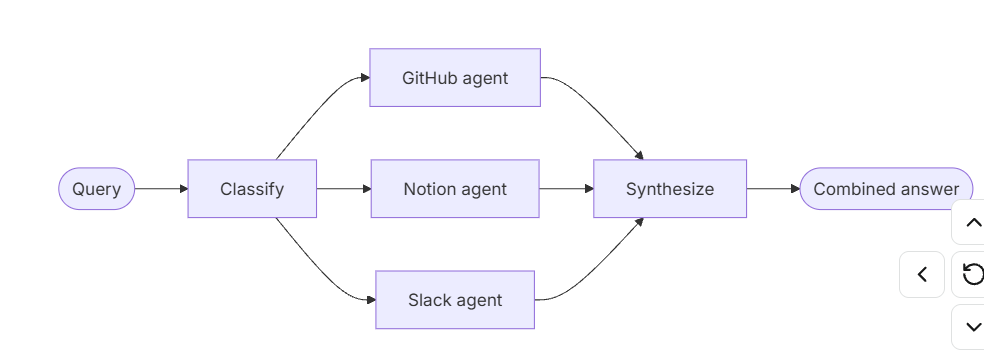

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# create Embedding function using Ollama
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="qwen3-embedding:0.6b",
    base_url="https://chat.ilawyer.com.vn/ollama")

In [2]:
# define LLM model first
import os

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="qwen3:30b",
                 api_key=os.getenv("OPEN_WEBUI_OPENAI_KEY"), 
                 base_url=os.getenv("OPEN_WEBUI_OPENAI_URL"),
                 temperature=0.5)

In [4]:
# Create Qdrant client
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
            url = os.getenv("QDRANT_URL"),
            port = 80,
            https = False,
            api_key = os.getenv("QDRANT_API_KEY"),
        )

/tmp/ipykernel_628198/2594988558.py:5: UserWarning: Api key is used with an insecure connection.
  qdrant_client = QdrantClient(


In [ ]:
# create collection in Qdrant
from qdrant_client.http.models import Distance, VectorParams

qdrant_client.create_collection(
    collection_name="20260118_semantic_search_collection",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

In [5]:
# Create the Qdrant vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="20260118_semantic_search_collection",
    embedding=embeddings,
)

In [7]:
# Define state
from typing import Annotated, Literal
from typing_extensions import TypedDict
import operator


class AgentInput(TypedDict):
    """Simple input state for each subagent."""
    query: str


class AgentOutput(TypedDict):
    """Output from each subagent."""
    source: str
    result: str


class Classification(TypedDict):
    """A single routing decision: which agent to call with what query."""
    source: Literal["github", "notion", "slack"]
    query: str


class RouterState(TypedDict):
    query: str
    classifications: list[Classification]
    results: Annotated[list[AgentOutput], operator.add]  # Reducer collects parallel results
    final_answer: str

In [ ]:
# Define tools for each vertical
from langchain.tools import tool

@tool
def search_code(query: str, repo: str = "main") -> str:
    """Search code in GitHub repositories."""
    return f"Found code matching '{query}' in {repo}: authentication middleware in src/auth.py"


@tool
def search_issues(query: str) -> str:
    """Search GitHub issues and pull requests."""
    return f"Found 3 issues matching '{query}': #142 (API auth docs), #89 (OAuth flow), #203 (token refresh)"


@tool
def search_prs(query: str) -> str:
    """Search pull requests for implementation details."""
    return f"PR #156 added JWT authentication, PR #178 updated OAuth scopes"

@tool
def search_notion(query: str) -> str:
    """Search Notion workspace for documentation."""
    return f"Found documentation: 'API Authentication Guide' - covers OAuth2 flow, API keys, and JWT tokens"

@tool
def get_page(page_id: str) -> str:
    """Get a specific Notion page by ID."""
    return f"Page content: Step-by-step authentication setup instructions"

@tool
def search_slack(query: str) -> str:
    """Search Slack messages and threads."""
    return f"Found discussion in #engineering: 'Use Bearer tokens for API auth, see docs for refresh flow'"

@tool
def get_thread(thread_id: str) -> str:
    """Get a specific Slack thread."""
    return f"Thread discusses best practices for API key rotation"

In [9]:
# 3. Create specialized agents
from langchain.agents import create_agent
# from langchain.chat_models import init_chat_model

# model = init_chat_model("openai:gpt-4o")

github_agent = create_agent(
    model,
    tools=[search_code, search_issues, search_prs],
    system_prompt=(
        "You are a GitHub expert. Answer questions about code, "
        "API references, and implementation details by searching "
        "repositories, issues, and pull requests."
    ),
)

notion_agent = create_agent(
    model,
    tools=[search_notion, get_page],
    system_prompt=(
        "You are a Notion expert. Answer questions about internal "
        "processes, policies, and team documentation by searching "
        "the organization's Notion workspace."
    ),
)

slack_agent = create_agent(
    model,
    tools=[search_slack, get_thread],
    system_prompt=(
        "You are a Slack expert. Answer questions by searching "
        "relevant threads and discussions where team members have "
        "shared knowledge and solutions."
    ),
)

In [10]:
# 4. Build the router workflow
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

# router_llm = init_chat_model("openai:gpt-4o-mini")
router_llm = model

# Define structured output schema for the classifier
class ClassificationResult(BaseModel):  
    """Result of classifying a user query into agent-specific sub-questions."""
    classifications: list[Classification] = Field(
        description="List of agents to invoke with their targeted sub-questions"
    )


def classify_query(state: RouterState) -> dict:
    """Classify query and determine which agents to invoke."""
    structured_llm = router_llm.with_structured_output(ClassificationResult)  

    result = structured_llm.invoke([
        {
            "role": "system",
            "content": """Analyze this query and determine which knowledge bases to consult.
For each relevant source, generate a targeted sub-question optimized for that source.

Available sources:
- github: Code, API references, implementation details, issues, pull requests
- notion: Internal documentation, processes, policies, team wikis
- slack: Team discussions, informal knowledge sharing, recent conversations

Return ONLY the sources that are relevant to the query. Each source should have
a targeted sub-question optimized for that specific knowledge domain.

Example for "How do I authenticate API requests?":
- github: "What authentication code exists? Search for auth middleware, JWT handling"
- notion: "What authentication documentation exists? Look for API auth guides"
(slack omitted because it's not relevant for this technical question)"""
        },
        {"role": "user", "content": state["query"]}
    ])

    return {"classifications": result.classifications}


def route_to_agents(state: RouterState) -> list[Send]:
    """Fan out to agents based on classifications."""
    return [
        Send(c["source"], {"query": c["query"]})  
        for c in state["classifications"]
    ]


def query_github(state: AgentInput) -> dict:
    """Query the GitHub agent."""
    result = github_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "github", "result": result["messages"][-1].content}]}


def query_notion(state: AgentInput) -> dict:
    """Query the Notion agent."""
    result = notion_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "notion", "result": result["messages"][-1].content}]}


def query_slack(state: AgentInput) -> dict:
    """Query the Slack agent."""
    result = slack_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "slack", "result": result["messages"][-1].content}]}


def synthesize_results(state: RouterState) -> dict:
    """Combine results from all agents into a coherent answer."""
    if not state["results"]:
        return {"final_answer": "No results found from any knowledge source."}

    # Format results for synthesis
    formatted = [
        f"**From {r['source'].title()}:**\n{r['result']}"
        for r in state["results"]
    ]

    synthesis_response = router_llm.invoke([
        {
            "role": "system",
            "content": f"""Synthesize these search results to answer the original question: "{state['query']}"

- Combine information from multiple sources without redundancy
- Highlight the most relevant and actionable information
- Note any discrepancies between sources
- Keep the response concise and well-organized"""
        },
        {"role": "user", "content": "\n\n".join(formatted)}
    ])

    return {"final_answer": synthesis_response.content}

In [11]:
# 5. Compile the workflow
workflow = (
    StateGraph(RouterState)
    .add_node("classify", classify_query)
    .add_node("github", query_github)
    .add_node("notion", query_notion)
    .add_node("slack", query_slack)
    .add_node("synthesize", synthesize_results)
    .add_edge(START, "classify")
    .add_conditional_edges("classify", route_to_agents, ["github", "notion", "slack"])
    .add_edge("github", "synthesize")
    .add_edge("notion", "synthesize")
    .add_edge("slack", "synthesize")
    .add_edge("synthesize", END)
    .compile()
)

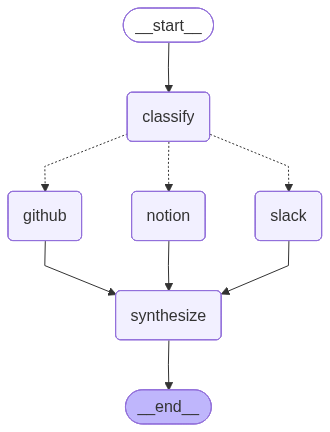

In [14]:
# display this workflow graph
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
# 6. Use the router
result = workflow.invoke({
    "query": "How do I authenticate API requests?"
})

print("Original query:", result["query"])
print("\nClassifications:")
for c in result["classifications"]:
    print(f"  {c['source']}: {c['query']}")
print("\n" + "=" * 60 + "\n")
print("Final Answer:")
print(result["final_answer"])

Original query: How do I authenticate API requests?

Classifications:
  github: What authentication methods are implemented in the API code? Search for auth middleware, token handling, or API key examples
  notion: Where is the official API authentication guide documented? Look for 'API Auth' or 'Developer Credentials' in internal docs


Final Answer:
Based on the provided search results, here's a concise synthesis for authenticating API requests:

### Key Information
1. **Official Documentation (Most Actionable)**  
   - The **"API Authentication Guide"** (located in *Developers > API Documentation* on Notion) is the authoritative resource.  
   - It covers **all required methods**:  
     - OAuth2 flow  
     - API key authentication  
     - JWT token validation  

2. **GitHub Code Context (Not for Client Use)**  
   - The `src/auth.py` file contains **backend implementation logic** (e.g., `@auth_required` decorators, token validation functions).  
   - **This is irrelevant for *you

In [ ]:
# Stateful routers
# need to add memory to store conversation history
from langgraph.checkpoint.memory import InMemorySaver
# The simplest way to add conversation memory is to wrap the stateless router as a tool that a conversational agent can call:

@tool
def search_knowledge_base(query: str) -> str:
    """Search across multiple knowledge sources (GitHub, Notion, Slack).

    Use this to find information about code, documentation, or team discussions.
    """
    result = workflow.invoke({"query": query})
    return result["final_answer"]


conversational_agent = create_agent(
    model,
    tools=[search_knowledge_base],
    system_prompt=(
        "You are a helpful assistant that answers questions about our organization. "
        "Use the search_knowledge_base tool to find information across our code, "
        "documentation, and team discussions."
    ),
    checkpointer=InMemorySaver(),
)